In [1]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *


In [2]:
# -------- Functions --------
def FD(dx, Nx):
    """Finite Difference operator for first derivative. First order accurate. All DBC."""
    return (1 / dx) * sp.diags([1, -1], [0, -1], shape=(Nx, Nx), format='lil')[:, :-1]


In [3]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny  = 200, 200
dx, dy = 1.0, 1.0
bcs = {'L': 'DBC', 'R': 'DBC', 'T': 'DBC', 'B': 'DBC'}

# -- Simulation parameters --
Nt = 100
dt = 3.0

# -- Initial Conditions --
# Pressure field (u)
f0 = 5.0            # Central frequency of the Ricker wavelet
x0, y0 = 50.0, 0.0  # Wavelet center
X, Y = np.meshgrid(np.linspace(-1, 1, Nx), np.linspace(-1, 1, Ny))
u0 = Ricker(f0, X, Y, 0, x0/Nx, y0/Ny)

# Particle velocity field x (vx)
v0x = np.zeros((Ny, (Nx-1)))

# Particle velocity field y (vy)
v0y = np.zeros(((Ny-1), Nx))

# -- Material properties --
# Velocity (c)
c0 = 1
c_model = c0 * np.ones((Ny, Nx))

# Density (rho)
rho0 = 1
rho_model = rho0 * np.ones((Ny, Nx))
rho_stag_x = rho0 * np.ones((Ny, (Nx-1)))
rho_stag_y = rho0 * np.ones(((Ny-1), Nx))


In [4]:
# -------- Matrix A (Acoustic) --------
# Finite difference operators
FD_x = FD(dx, Nx)
FD_y = FD(dy, Ny)

# Boundary conditions (Dirichlet or Neumann)
if bcs['L'] == 'NBC': FD_x[0, :] = 0 
if bcs['R'] == 'NBC': FD_x[-1, :] = 0
if bcs['T'] == 'NBC': FD_y[0, :] = 0 
if bcs['B'] == 'NBC': FD_y[-1, :] = 0

# Derivative operators
D_x = sp.kron(sp.eye(Ny), FD_x)
D_y = sp.kron(FD_y, sp.eye(Nx))

# Divergence & Gradient operators
Div = sp.hstack([D_x, D_y], format='csr')
Grad = -Div.T

# System matrix A
A = sp.bmat([
    [None, Div],
    [Grad, None]
], format='csr')


In [5]:
# -------- Matrix B (Acoustic) --------
# Flatten the arrays
c_model = c_model.flatten()
rho_model = rho_model.flatten()
rho_stag_x = rho_stag_x.flatten()
rho_stag_y = rho_stag_y.flatten()

# Material matrices for u and v (sqrt)
B_u_sqrt = sp.diags(1 / np.sqrt(rho_model * c_model ** 2), format='csr')
B_vx_sqrt = sp.diags(np.sqrt(rho_stag_x), format='csr')
B_vy_sqrt = sp.diags(np.sqrt(rho_stag_y), format='csr')
B_sqrt = sp.block_diag([B_u_sqrt, B_vx_sqrt, B_vy_sqrt], format='csr')

# Material matrices for u and v (sqrt_inv)
B_u_inv_sqrt = sp.diags(np.sqrt(rho_model * c_model ** 2), format='csr')
B_vx_inv_sqrt = sp.diags(1 / np.sqrt(rho_stag_x), format='csr')
B_vy_inv_sqrt = sp.diags(1 / np.sqrt(rho_stag_y), format='csr')
B_inv_sqrt = sp.block_diag([B_u_inv_sqrt, B_vx_inv_sqrt, B_vy_inv_sqrt], format='csr')


In [6]:
# -------- Hamiltonian (acoustic) --------
H = 1j * B_inv_sqrt @ A @ B_inv_sqrt
print('Hermitian:', not (H - H.conj().T).nnz)
print('Hamiltonian Size:', H.shape)


Hermitian: True
Hamiltonian Size: (119600, 119600)


In [7]:
# -------- Initial State  --------
# Stack the initial conditions
phi_0 = np.hstack([u0.flatten(), v0x.flatten(), v0y.flatten()])

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm


In [8]:
# -------- Time Evolution --------
# Evolve the state over time (energy basis)
psi_t = sp.linalg.expm_multiply(-1j * H, psi_0, start=0, stop=Nt*dt, num=Nt, endpoint=True).real


In [9]:
# -------- Final State --------
# Transform the state back to the original basis
phi_t = norm * (B_inv_sqrt @ psi_t.T).T


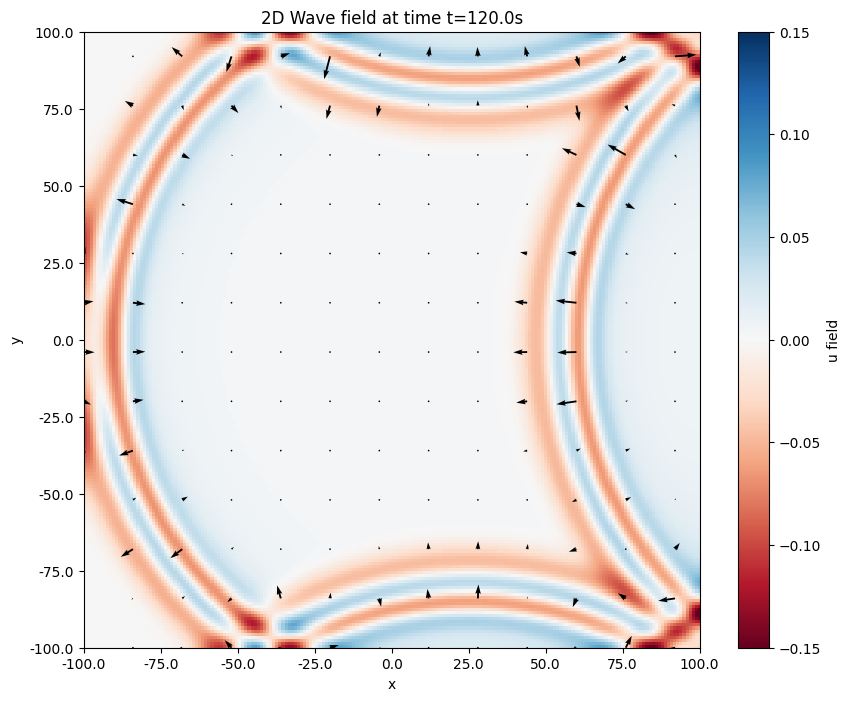

In [10]:
# -------- Plot --------
t_plot = 40
plot_acoustic_2D(phi_t[t_plot], Nx, Ny, dx, dy, title=f'2D Wave field at time t={t_plot*dt}s')


In [11]:
# -------- Total Energy Conservation --------
N = Nx * Ny # Number of grid points
V = dx * dy # Volume of each grid cell

EN0 = (1/2) * np.linalg.norm(B_sqrt @ phi_0)**2 * V * N
print('Initial Energy:', EN0.round(4))

ENT = (1/2) * np.linalg.norm(B_sqrt @ phi_t.T, axis=0)**2 * V * N
print('Final Energy:', ENT[-1].round(4))


Initial Energy: 1260538.9803
Final Energy: 1260538.9803
